In [261]:
#Since raw text cannot be used directly in neural networks, the data is converted into continuous-valued vectors.
# The process of converting data into vector format is called embedding.

In [262]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

print("Total number of characters:", len(raw_text))
print(raw_text[:99])

Total number of characters: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [263]:
import re

In [264]:
text = "Hello world, this is a test."
result = re.split(r'(\s)', text)
print(result)

['Hello', ' ', 'world,', ' ', 'this', ' ', 'is', ' ', 'a', ' ', 'test.']


In [265]:
#We refrain from making all text lowercase because capitalization helps LLMs distinguish between proper nouns and common nouns, understand sentence 
#structure, and learn to generate text with proper capitalization

In [266]:
result = re.split(r'([, .]|\s)', text)
print(result)

['Hello', ' ', 'world', ',', '', ' ', 'this', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


In [267]:
#Result include whitespace characters, it can be excluded
result = [item for item in result if item.strip()]
print(result)

['Hello', 'world', ',', 'this', 'is', 'a', 'test', '.']


In [268]:
#Here one thing to be noted that, if we are building our LLM for writing a python code or any code in general, they will be sensitive to
#indentation and spaces, in that case it becomes important to keep whitespaces.

In [269]:
text = "Hello, world. Is this--a test? "
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'Is', ' ', 'this', '--', 'a', ' ', 'test', '?', '', ' ', '']


In [270]:
preprocessed = re.split(r'([,.?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(len(preprocessed))
print(preprocessed[:30])

4649
['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


In [271]:
all_words = sorted(list(set(preprocessed)))
vocab_size = len(all_words)
print(vocab_size)

1159


In [272]:
vocab = {token:integer for integer,token in enumerate(all_words)}
for i, item in enumerate(vocab.items()):
    print(item)
    if i > 50:
        break


('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Carlo;', 25)
('Chicago', 26)
('Claude', 27)
('Come', 28)
('Croft', 29)
('Destroyed', 30)
('Devonshire', 31)
('Don', 32)
('Dubarry', 33)
('Emperors', 34)
('Florence', 35)
('For', 36)
('Gallery', 37)
('Gideon', 38)
('Gisburn', 39)
('Gisburns', 40)
('Grafton', 41)
('Greek', 42)
('Grindle', 43)
('Grindle:', 44)
('Grindles', 45)
('HAD', 46)
('Had', 47)
('Hang', 48)
('Has', 49)
('He', 50)
('Her', 51)


In [273]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])
vocab = {token:integer for integer,token in enumerate(all_tokens)}
print(len(vocab.items()))

1161


In [274]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}

    def encode(self, text):
        preprocessed = re.split(r'([,.?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [item if item in self.str_to_int else "<|unk|>" for item in preprocessed]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids

    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text) 
        return text

In [275]:
#Testing the tokenizer class
tokenizer = SimpleTokenizerV1(vocab)
text = """"It's the last, he painted, you know" Mrs. Gisburn said with"""
ids = tokenizer.encode(text)
print(ids)
print(tokenizer.decode(ids))

[1, 58, 2, 872, 1013, 615, 5, 541, 763, 5, 1155, 608, 1, 69, 7, 39, 873, 1136]
" It' s the last, he painted, you know" Mrs. Gisburn said with


In [276]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)
#Similarly the code in simpletokenizer class is updated

('younger', 1156)
('your', 1157)
('yourself', 1158)
('<|endoftext|>', 1159)
('<|unk|>', 1160)


In [277]:
text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."
text = " <|endoftext|> ".join((text1, text2))
print(text)
tokenizer = SimpleTokenizerV1(vocab)
print(tokenizer.encode(text))
print(tokenizer.decode(tokenizer.encode(text)))

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.
[1160, 5, 362, 1155, 642, 1000, 10, 1159, 57, 1013, 981, 1009, 738, 1013, 1160, 7]
<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.


In [278]:
#The tokenization used was a simple one. Let's use Byte Pair Encoding(BPE). It is more sophisticated and used in GPT
import tiktoken

In [279]:
tokenizer = tiktoken.get_encoding("gpt2")

In [280]:
text = "Hello, do you like tea? <|endoftext|> In the sunlit terraces of some place"
integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(integers)
strings = tokenizer.decode(integers)
print(strings)


[15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 286, 617, 1295]
Hello, do you like tea? <|endoftext|> In the sunlit terraces of some place


In [281]:
#We can make two noteworthy observations based on the token IDs and decoded text above. First, the <|endoftext|> token is assigned a relatively large 
#token ID, namely, 50256. In fact, the BPE tokenizer, which was used to train models such as GPT-2, GPT-3, and the original model used in ChatGPT, 
#has a total vocabulary size of 50,257, with <|endoftext|> being assigned the largest token ID.
#The algorithm underlying BPE breaks down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, 
#enabling it to handle out-of-vocabulary words. So, thanks to the BPE algorithm, if the tokenizer encounters an unfamiliar word during tokenization, 
#it can represent it as a sequence of subword tokens

In [282]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
enc_text = tokenizer.encode(raw_text)
print(len(enc_text)) #After applying BPE tokenizer

5145


In [283]:
#for LLM the input is text and output is the word next to it
#consider this example
enc_sample = enc_text[50:]
context_size = 4
x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]
print(f"x:   {x}")
print(f"y:        {y}")

x:   [290, 4920, 2241, 287]
y:        [4920, 2241, 287, 257]


In [284]:
#Here is how LLM will recieve input and the corresponding desired output
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [285]:
#Above code represent the token Id, Let's do it for the tokens
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]
    print(tokenizer.decode(context), "---->", tokenizer.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


In [286]:
#Now, for this project, we will handle two tensors an input and an output tensors for LLM
#Encode method of BPE tokenizer performs both tokenization and conversion into token IDs as a single step

In [287]:
#Relevant libraries for pytorch
import torch
from torch.utils.data import Dataset, DataLoader

In [288]:
class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.tokenizer = tokenizer
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i+max_length]
            target_chunk = token_ids[i+1: i+max_length+1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [289]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, stride=128, shuffle=True, drop_last=True):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last
    )

    return dataloader

In [290]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=4, stride=1, shuffle=False
) 
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[  40,  367, 2885, 1464]]), tensor([[ 367, 2885, 1464, 1807]])]


In [291]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[ 367, 2885, 1464, 1807]]), tensor([[2885, 1464, 1807, 3619]])]


In [292]:
#Batch size of 1 require less memory size during training but lead to more noisy model updates.
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=1, shuffle=False)

data_iter = iter(dataloader)

inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [  367,  2885,  1464,  1807],
        [ 2885,  1464,  1807,  3619],
        [ 1464,  1807,  3619,   402],
        [ 1807,  3619,   402,   271],
        [ 3619,   402,   271, 10899],
        [  402,   271, 10899,  2138],
        [  271, 10899,  2138,   257]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 2885,  1464,  1807,  3619],
        [ 1464,  1807,  3619,   402],
        [ 1807,  3619,   402,   271],
        [ 3619,   402,   271, 10899],
        [  402,   271, 10899,  2138],
        [  271, 10899,  2138,   257],
        [10899,  2138,   257,  7026]])


In [293]:
#creating token embeddings since LLM are deep neural networks
input_ids = torch.tensor([2,3,5,1])
vocab_size = 6
output_dim = 3
torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)
print(embedding_layer.weight)
#weight matrix of embedding layer contains small random values, these values are optimized during the LLM training

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


In [294]:
#There is one row for each of the six possible tokens in the vocabulary. And one column for each three embedding dimensions
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


In [295]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


In [296]:
#The same token id gets mapped to the same vector representation, regardless of where token id is positioned.
#It is important to add additional position information into the LLM.
#Positions embeddings: relative positional embeddings and absolute positional embeddings
#More emphasis on relative position embeddings i.e. focussing on "how far appart" rather than "at which exact positions" of token ids.

In [297]:
#Token Embeddings are suitable inputs for LLMs
output_dim = 256
vocab_size = 50257
token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

In [298]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length, stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


In [299]:
token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

torch.Size([8, 4, 256])


In [300]:
context_length = max_length

pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([4, 256])


In [301]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([8, 4, 256])


In [302]:
#While token embeddings provide consistent vector representations for each token, they lack a sense of the token's position in a sequence. To rectify 
#this, two main types of positional embeddings exist: absolute and relative. OpenAI's GPT models utilize absolute positional embeddings that are added 
#to the token embedding vectors and are optimized during the model training.

In [303]:
#The embedding weights are initialized with random values as preliminary step. These are important to convert token Ids into continous
#vector representation, which serve as the input for LLM, which is essentially a deep neural networks. Not to forget it is trained with backpropagation algorithm.


In [304]:
inputs = torch.tensor(
[[0.43, 0.15, 0.89], # Your (x^1)
[0.55, 0.87, 0.66], # journey (x^2)
[0.57, 0.85, 0.64], # starts (x^3)
[0.22, 0.58, 0.33], # with (x^4)
[0.77, 0.25, 0.10], # one (x^5)
[0.05, 0.80, 0.55]] # step (x^6)
)

query = inputs[1] 
attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)
print(attn_scores_2)


tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


In [305]:
res = 0
for idx, element in enumerate(inputs[0]):
    res += inputs[0][idx]*query[idx]
print(res)
print(torch.dot(inputs[0], query))

tensor(0.9544)
tensor(0.9544)


In [306]:
#The dot product is of input and query sequence, which is next element.
#Beyond viewing the dot product operation as a mathematical tool that combines two vectors to yield a scalar value, the dot product is a measure of
#similarity because it quantifies how much two vectors are aligned: a higher dot product indicates a greater degree of alignment or similarity between the
#vectors. In the context of self-attention mechanisms, the dot product determines the extent to which elements in a sequence attend to each other:
#the higher the dot product, the higher the similarity and attention score between two elements.

In [307]:
#The main goal behind the normalization shown is to obtain attention weights that sum up to 1. This normalization is a convention that is useful for 
#interpretation and for maintaining training stability in an LLM
attn_weights_2_tmp = attn_scores_2 / attn_scores_2.sum()
print("Attention weights:", attn_weights_2_tmp)
print("Sum:", attn_weights_2_tmp.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


In [308]:
#Using softmax function for normalization, it ensures attention weights are always positive
def softmax_naive(x):
    return torch.exp(x)/torch.exp(x).sum(dim=0)
attn_weights_2_naive = softmax_naive(attn_scores_2)
print("Attention weights:", attn_weights_2_naive)
print("Sum:", attn_weights_2_naive.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [309]:
#The above output are interpretable as probabilities or relative importance. Higher weights means greater importance
#Now using the pytorch's implementation of softmax
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)
print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


In [310]:
#Now the context vector z is calculated as a weighted sum of all input vectors. It includes multiplying input vector with its corresponding attention weights.
query = inputs[1]
context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


In [311]:
#The above attention weight was of second input element "journey". Now for entire sentence
attn_scores = torch.empty(6,6)
for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, x_j)
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [312]:
#Instead of using for loops, let's do it quiker and simpler way
attn_scores = inputs@inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [313]:
#Now normalize each row such that sum of each row is equal to one.
attn_weights = torch.softmax(attn_scores, dim=1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [314]:
#Checking the sum of rows
row_2_sum = sum([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
print("Row 2 sum:", row_2_sum)
print("All row sums:", attn_weights.sum(dim=1))

Row 2 sum: 1.0
All row sums: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


In [315]:
#Now calculating the context vector
all_context_vecs = attn_weights @ inputs
print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [316]:
#For example consider only one context vector
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

In [317]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [318]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value
print(query_2)

tensor([0.4306, 1.4551])


In [319]:
#Now obtaining all keys and values
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [320]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [321]:
attn_scores_2 = query_2 @ keys.T
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


In [322]:
#Now after finding attention scores, now it is time to use softmax function to find the attention weights.
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2/d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


In [323]:
#Now context vectors
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


In [324]:
#query - search query in database. It represent current item.
#key - used for indexing and searching, used to match with query.
#value - similar to key value pair in database.

In [325]:
#Now organizing the above codes into a python class
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        context_vec = attn_weights @ values
        return context_vec

In [326]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


In [327]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [328]:
#since nn.Linear uses more sophisticated weight initialization, the output will be different
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


In [329]:
#Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they use different initial weights for the weight matrices since
#nn.Linear uses a more sophisticated weight initialization scheme.

In [330]:
#Casual attention mask
queries = sa_v2.W_query(inputs)
keys = sa_v2.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [331]:
context_length = attn_scores.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


In [332]:
#Multiply with attention weights to zero the diagonals
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)


In [333]:
#Again renormalizing the attention weights
row_sums = masked_simple.sum(dim=1, keepdim=True)
masked_simple_norm = masked_simple/row_sums
print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


In [334]:
#More efficient way is to mask attention scores with negative infinity values
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


In [335]:
#Again applying softmax function
attn_weights = torch.softmax(masked/keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


In [336]:
#To prevent overfitting, randomly selected hidden layer units are ignored during training.
#Here we will apply the dropout mask after computing the attention weights
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6, 6)
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [337]:
#The above matrix is scaled, since 50% of values are reduced to zero, rest 50% are increased to 2.
#Now applying dropout to our attention weight matrix
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.8966, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4921, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4350, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


In [338]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [339]:
class CasualAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            'mask',
            torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores/keys.shape[-1]**0.5, dim=-1)

        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values
        return context_vec

In [340]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CasualAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


In [341]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        # Create a list of CausalAttention heads
        self.heads = nn.ModuleList([
            CasualAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)
        ])
    
    def forward(self, x):
        # Apply each attention head to the input and concatenate the outputs
        return torch.cat([head(x) for head in self.heads], dim=-1)

In [342]:
torch.manual_seed(123)

# Example batch input tensor (batch_size=2, num_tokens=5, d_in=3)
batch = torch.randn(2, 5, 3)

# Extract context length from the batch (number of tokens)
context_length = batch.shape[1]

# Input and output dimensions for each attention head
d_in, d_out = 3, 2

# Define number of attention heads
num_heads = 4

# Initialize the MultiHeadAttentionWrapper with dropout set to 0.0
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, dropout=0.0, num_heads=num_heads)

# Pass the batch through the multi-head attention
context_vecs = mha(batch)

# Print the output context vectors and their shape
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[ 0.0671,  0.3759,  0.1906,  0.0834, -0.2695,  0.0855,  0.1404,
           0.0812],
         [-0.0255, -0.1609, -0.0815, -0.0234,  0.1689, -0.0391, -0.0457,
          -0.0262],
         [ 0.0591, -0.1720, -0.0297, -0.0817,  0.2631, -0.1513, -0.0832,
           0.0431],
         [-0.0906, -0.2119, -0.1133, -0.1110, -0.0358, -0.0650, -0.1195,
          -0.1228],
         [-0.2134, -0.5350, -0.2792,  0.0115,  0.2884,  0.0613, -0.1142,
          -0.1195]],

        [[ 0.5806, -0.1113,  0.3619, -1.0039,  0.3026, -1.2578, -0.4240,
           0.4896],
         [-0.1215, -0.9013, -0.3617, -0.7995,  0.3469, -0.7924, -0.5056,
           0.0874],
         [-0.3242, -0.9644, -0.6044, -0.4799,  0.3213, -0.4401, -0.4670,
          -0.0200],
         [-0.2342, -0.8020, -0.5235, -0.1915,  0.3237, -0.2161, -0.3542,
          -0.1938],
         [-0.3371, -0.7308, -0.5518, -0.1269,  0.2574, -0.0218, -0.2757,
          -0.3226]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 5, 8])


In [343]:
#Combining the MultiHeadAttentionWraper and CausalAttention into single class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out//num_heads

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

        self.out_proj = nn.Linear(d_out, d_out)

        self.dropout = nn.Dropout(dropout)

        self.register_buffer(
            'mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(-2,-1)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, float('-inf'))

        attn_weights = torch.softmax(attn_scores / (self.head_dim**0.5), dim=-1)

        attn_weights = self.dropout(attn_weights)
        context_vec = attn_weights @ values

        context_vec = context_vec.transpose(1, 2)

        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)

        context_vec = self.out_proj(context_vec)
        return context_vec

In [344]:
torch.manual_seed(123)
batch_size = 3
context_length = 5
d_in = 4
batch = torch.rand(batch_size, context_length, d_in)
d_out = 2
num_heads = 2
mha = MultiHeadAttention(d_in, d_out, context_length, dropout=0.0, num_heads=num_heads)
context_vecs = mha(batch)

print("Context Vectors:\n", context_vecs)
print("Context Vectors Shape:", context_vecs.shape)

Context Vectors:
 tensor([[[0.3534, 0.2698],
         [0.4384, 0.3512],
         [0.4285, 0.3398],
         [0.4114, 0.3161],
         [0.4165, 0.3216]],

        [[0.2463, 0.2878],
         [0.3035, 0.2797],
         [0.2544, 0.2600],
         [0.2794, 0.3025],
         [0.2991, 0.2918]],

        [[0.2466, 0.1752],
         [0.2942, 0.2428],
         [0.3016, 0.3003],
         [0.3301, 0.3370],
         [0.3675, 0.3662]]], grad_fn=<ViewBackward0>)
Context Vectors Shape: torch.Size([3, 5, 2])


In [345]:
GPT_CONFIG_124M = {
"vocab_size": 50257, # Vocabulary size
"context_length": 1024, # Context length
"emb_dim": 768, # Embedding dimension
"n_heads": 12, # Number of attention heads
"n_layers": 12, # Number of layers
"drop_rate": 0.1, # Dropout rate
"qkv_bias": False # Query-Key-Value bias
}

In [346]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()

    def forward(self, x):
        return x

class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()

    def forward(self, x):
        return x

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        x = self.trf_blocks(x)

        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [347]:
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [348]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


In [349]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
 

In [350]:
#GELU activation function
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


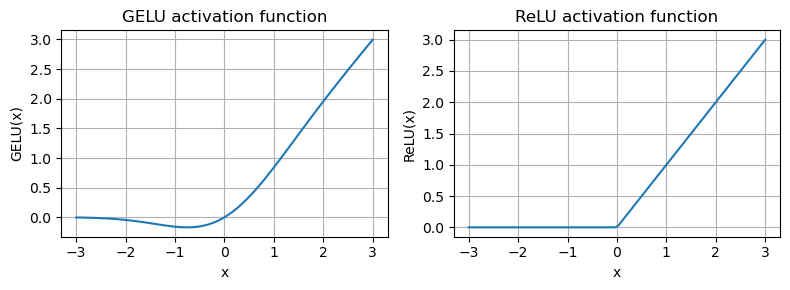

In [351]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Define GELU activation function
def gelu(x):
    return 0.5 * x * (1 + torch.tanh(
        torch.sqrt(torch.tensor(2.0 / torch.pi)) *
        (x + 0.044715 * torch.pow(x, 3))
    ))

# Use PyTorch's built-in ReLU
def relu(x):
    return F.relu(x)

# Input values
x = torch.linspace(-3, 3, 100)

# Compute the activations
y_gelu = gelu(x)
y_relu = relu(x)

# Plot the functions
plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x.numpy(), y.numpy())  # Convert tensors to numpy arrays for plotting
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

In [352]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super(FeedForward, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4*cfg["emb_dim"]),
            nn.GELU(),
            nn.Linear(4*cfg["emb_dim"], cfg["emb_dim"]),
        )
    def forward(self, x):
        return self.layers(x)

In [353]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


In [354]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut=False):
        super(ExampleDeepNeuralNetwork, self).__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[i], layer_sizes[i+1]), nn.GELU())
            for i in range(len(layer_sizes) - 1)
        ])

    def forward(self, x):
        for layer in self.layers:
            layer_output = layer(x)
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x

In [355]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(layer_sizes, use_shortcut=False)

output_without_shortcut = model_without_shortcut(sample_input)

print("Model output without shortcut:", output_without_shortcut)

Model output without shortcut: tensor([[0.0610]], grad_fn=<GeluBackward0>)


In [356]:
def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([[0.]])

    loss_fn = nn.MSELoss()
    loss = loss_fn(output, target)

    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [357]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.0002017411752603948
layers.1.0.weight has gradient mean of 0.00012011770741082728
layers.2.0.weight has gradient mean of 0.0007152437465265393
layers.3.0.weight has gradient mean of 0.0013988513965159655
layers.4.0.weight has gradient mean of 0.005049604922533035


In [358]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22186797857284546
layers.1.0.weight has gradient mean of 0.207092747092247
layers.2.0.weight has gradient mean of 0.32923877239227295
layers.3.0.weight has gradient mean of 0.2667771875858307
layers.4.0.weight has gradient mean of 1.3268063068389893


In [359]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_resid(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut

        return x

In [360]:
#Layer normalization (LayerNorm) is applied before each of these two components, and dropout is applied after them to regularize the model and
#prevent overfitting. This is also known as Pre-LayerNorm. Older architectures, such as the original transformer model, applied layer
#normalization after the self-attention and feed-forward networks instead, known as Post-LayerNorm, which often leads to worse training dynamics.

In [361]:
#Feeding some sample data to transformer block
torch.manual_seed(123)
x = torch.rand(2, 4, 768)
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


In [362]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape

        tok_embeds = self.tok_emb(in_idx)

        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))

        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)

        x = self.trf_blocks(x)

        x = self.final_norm(x)

        logits = self.out_head(x)

        return logits

In [363]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1380,  0.0077, -0.1964,  ..., -0.0223, -0.1060,  0.1716],
         [ 0.3864, -0.8408, -0.6565,  ..., -0.5163,  0.2369, -0.3358],
         [ 0.6988, -0.1828, -0.1630,  ...,  0.1472, -0.6504, -0.0057],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1093, -0.2894, -0.1467,  ..., -0.0558,  0.2910, -0.2824],
         [ 0.0882, -0.3552, -0.3526,  ...,  1.2929,  0.0053,  0.1897],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3788, -0.1974],
         [-0.0613, -0.0736,  0.4750,  ...,  1.2462, -0.3835,  0.0608]]],
       grad_fn=<UnsafeViewBackward0>)


In [364]:
#Input tensors have ids of two text input with four tokens and output has shape of [2, 4, 50257] Here 50257 is vocabulary size of tokenizer

In [365]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [366]:
#Why is there 163 million parameter, when GPT_2 has 124 million?
#The reason is a concept called weight tying that is used in the original GPT-2 architecture, which means that the original GPT-2 architecture is reusing the
#weights from the token embedding layer inits output layer. 

In [367]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [368]:
#The token embedding and output layers are very large due to the number of rows for the 50,257 in the tokenizer's vocabulary. Removing output layer parameters from GPT-2 model count
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters() if p.requires_grad)
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2}")

Number of trainable parameters considering weight tying: 124412160


In [369]:
#Now the number of parameters is matching the total size of GPT-2 model. But weight tying is necessary to reduce the overall memory footprint and  computational complexity of the model.
#Now computing the memory requirements for 163 million parameters.
total_size_bytes = total_params*4
total_size_mb = total_size_bytes / (1024*1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


In [370]:
#Even a small LLM require 621 MB. Here each parameter is a 32-bit float taking up 4 bytes.

In [371]:
#Now converting the output tensors back to text. It requires decoding the output tensors, selecting token based on probability distribution
#and converting these tokens into human-readable text. The vector corresponding to the next token is extracted and converted into a probability 
#distribution via softmax function. Within the vector containing the resulting probability scores, the index of the highest
#value is located, which translates to the token ID. This token ID is then decoded back into text, producing the next token in the sequence. Finally, this
#token is appended to the previous inputs, forming a new input sequence for the subsequent iteration. This step-by-step process enables the model to
#generate text sequentially, building coherent phrases and sentences from the initial input context.

In [372]:
#Token generating process
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        probas = torch.softmax(logits, dim=-1)

        idx_next = torch.argmax(probas, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [373]:
# In the preceeding code, the generate_text_simple function, we use a softmax function to convert the logits into a probability distribution from
#which we identify the position with the highest value via torch.argmax.

In [374]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [375]:
model.eval()
out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"],
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [376]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


In [377]:
#The model produced gibberish. It didn't produced coherent text because it was not trained. We just implemented GPT architecture
#with initial random weights.

In [378]:
GPT_CONFIG_124M = {
"vocab_size": 50257, 
"context_length": 256, 
"emb_dim": 768, 
"n_heads": 12, 
"n_layers": 12, 
"drop_rate": 0.1, 
"qkv_bias": False 
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Lin

In [379]:
#Reduced the context length to 256 tokens. It reduces the computational demand of training model, allowing it to be trained on the standard laptop.
import tiktoken
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [500]:
#Simple example
inputs = torch.tensor([[16833, 3626, 6100], [40, 1107, 588]])
targets = torch.tensor([[3626, 6100, 345], [588, 428, 11311]])

In [502]:
with torch.no_grad():
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [504]:
#Applying argmax to probability scores
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [508]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


In [510]:
#Text is generated but the model is not trained. Thats why undesired result.
#Since the vocabulary we are using contains 50,257 tokens, therefore initial probabilities hover around 1/50257 i.e 0.00002
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx, [0, 1, 2]]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx, [0, 1, 2]]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4536e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([3.9834e-05, 1.6783e-05, 4.7559e-06])


In [512]:
#The goal of training an LLM is to maximize these values, aiming to get them as close to a probability of 1. This way, we ensure the LLM consistently
#picks the target token—essentially the next word in the sentence—as the next token it generates.
#Updation of weights is done via backpropagation.
#Applying log of probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print("Log probabilities:", log_probas)

Log probabilities: tensor([ -9.5042, -10.3796, -11.3677, -10.1308, -10.9951, -12.2561])


In [514]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7723)


In [516]:
# The goal is to get the average log probability as close to 0 as possible by updating the model's weights as part of the training process
#However, in deep learning, the common practice isn't to push the average log probability up to 0 but rather to bring the negative average log probability
#down to 0. The negative average log probability is simply the average log probability multiplied by -1
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7723)


In [518]:
#This value is known as cross entropy loss.
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [520]:
#Flatten these tensors
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [524]:
#Earlier we applied softmax function, selected the probability scores and computed the negative average log probabilities. 
#Py-torch cross-entropy function will take care of all these.
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross-entropy loss:", loss)

Cross-entropy loss: tensor(10.7723)


In [526]:
file_path = "the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [528]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [530]:
#90% data for training and 10% for validation
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [532]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False
)

In [534]:
print("Train loader:")
for x,y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x,y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [536]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)

    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0,1), target_batch.flatten()
    )
    return loss

In [538]:
#Computing training and validation loss
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0
    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [540]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
train_loss = calc_loss_loader(train_loader, model, device)
val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758210076226
Validation loss: 10.98110580444336


In [550]:
#The loss value is high, since the model is not trained, as it trains, the loss value approaches 0.
def train_model_simple(
    model, train_loader, val_loader, optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context
):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(
                    f"Ep {epoch + 1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}"
                )
        generate_and_print_sample(
            model, train_loader.dataset.tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [552]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [554]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)

    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model,
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )

        decoded_text = token_ids_to_text(token_ids, tokenizer)

        print(decoded_text.replace("\n", " "))

    model.train()

In [556]:
#We are using AdamW optimizer, it minimize model complexity and prevents overfitting by penalizing larger weights.
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.01)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=1,
    start_context="Every effort moves you"
)

Ep 1 (Step 000000): Train loss 9.830, Val loss 9.927
Ep 1 (Step 000005): Train loss 8.133, Val loss 8.334
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.770, Val loss 7.047
Ep 2 (Step 000015): Train loss 6.497, Val loss 6.573
Every effort moves you, and,, and, and,,,,, and, and,,,,,,,,,,,,,, and,,,, and,, and,,,,, and,,,,,,
Ep 3 (Step 000020): Train loss 5.578, Val loss 6.491
Ep 3 (Step 000025): Train loss 4.731, Val loss 6.386
Every effort moves you, and to the picture.                      "I, and the of the of the's the honour, and, and I had been, and I
Ep 4 (Step 000030): Train loss 5.281, Val loss 6.361
Ep 4 (Step 000035): Train loss 3.851, Val loss 6.261
Every effort moves you of the to the picture to the of the picture--and a of the picture.         "I was the picture--as Jack's the his pictures--and it the picture and I was his I was his
Ep 5 (Step 000040): Train loss 3.658, Val loss 6.198
Every effort moves you know t

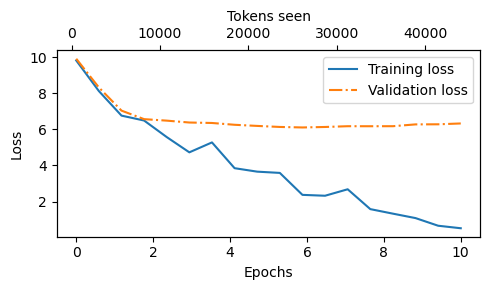

In [558]:
import matplotlib.pyplot as plt

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")

    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses)).numpy()
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [560]:
#This divergence and the fact that the validation loss is much larger than the training loss indicate that the model is overfitting to the training data. We can
#confirm that the model memorizes the training data verbatim by searching for the generated text snippets, such as "quite insensible to the irony" in
#the "The Verdict" text file. This memorization is expected since we are working with a very, very small
#training dataset and training the model for multiple epochs. Usually, it's common to train a model on a much, much larger dataset for only one epoch.
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Lin

In [562]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [572]:
def generate(model, idx, max_new_tokens, context_size, temperature, top_k=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [574]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to my surprise, a little it was the
"Ah enough


In [576]:
#The generated text is different from previous one where the model memorized it.
#Saving the PyTorch model
torch.save(model.state_dict(), "model.pth")

In [578]:
#Loading the model weights into the new GPTModel
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

C:\Users\adity\AppData\Local\Temp\ipykernel_27940\4111636023.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Lin

In [580]:
# Adaptive optimizers such as AdamW store additional parameters for each model weight. AdamW uses historical data to adjust learning rates for each
#model parameter dynamically. Without it, the optimizer resets, and the model may learn suboptimally or even fail to converge properly, which means that it
#will lose the ability to generate coherent text. . Using torch.save, we can save both the model and optimizer state_dict contents as follows
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
},
          "model_and_optimizer.pth")

In [582]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

C:\Users\adity\AppData\Local\Temp\ipykernel_27940\4016816238.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("model_and_optimizer.pth")


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Lin

In [584]:
#Fortunately, OpenAI openly shared the weights of their GPT-2 models, thus eliminating the need to invest tens to hundreds of thousands of dollars in
#retraining the model on a large corpus ourselves.
#OpenAI saved the weights via TensorFlow

In [586]:
import urllib.request

In [588]:
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
 )
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)

('gpt_download.py', <http.client.HTTPMessage at 0x208dc457a40>)

In [592]:
from gpt_download import download_and_load_gpt2

model_size = "124M"
models_dir = "./models"
settings, params = download_and_load_gpt2(model_size=model_size, models_dir=models_dir)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 70.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:02<00:00, 369kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 47.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [08:56<00:00, 928kiB/s]    
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<?, ?iB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:02<00:00, 229kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:02<00:00, 203kiB/s]  


In [594]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [596]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [598]:
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
 }

In [600]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024})
NEW_CONFIG.update({"qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linea

In [602]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [608]:
#Loading the weights
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])  # A
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):  # B
        # Split the 'w' key for query, key, value weights
        q_w, k_w, v_w = np.split(params["blocks"][b]["attn"]["c_attn"]["w"], 3, axis=-1)  # C
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        # Split the 'b' key for query, key, value biases
        q_b, k_b, v_b = np.split(params["blocks"][b]["attn"]["c_attn"]["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

        # Assign weights and biases for the attention output projection
        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

        # Assign weights and biases for the feed-forward layers
        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

        # Assign layer normalization weights and biases
        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

    # Assign weights and biases for the final normalization
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    # Assign weights for the output head
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])

    return gpt

In [610]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linea

In [612]:
torch.manual_seed(123)
token_ids = generate(
model=gpt,
idx=text_to_token_ids("Every effort moves you", tokenizer),
max_new_tokens=25,
context_size=NEW_CONFIG["context_length"],
top_k=50,
temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward an equal share for each vote plus half. Inequality is often not an accurate representation of human worth; to know the


In [614]:
#The model reproduced the coherent text. Hence model weights were loaded correctly.